# Project goal - Gold recovery prediction
In this project, we need to prepare a prototype of a machine learning model for `Zyfra`. The company develops efficiency solutions for heavy industry. The model should predict the amount of gold recovered from gold ore. We have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.
 
**We need to predict two values:**
- rougher concentrate recovery `rougher.output.recovery`
- final concentrate recovery `final.output.recovery`

The data is stored in three files:
- /datasets/gold_recovery_train.csv
- /datasets/gold_recovery_test.csv
- /datasets/gold_recovery_full.csv

Data is indexed with the date and time of acquisition (`date` feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.
You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data.

# Data description
**Technological process**
- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate — promoter or flotation activator;
    - Sulphate — sodium sulphide for this particular process;
    - Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate

**Parameters of stages**
- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate

**Feature naming**
Here's how you name the features:
`[stage].[parameter_type].[parameter_name]`

Example: `rougher.input.feed_ag`:

*Possible values for* `[stage]`:
- rougher — flotation
- primary_cleaner — primary purification
- secondary_cleaner — secondary purification
- final — final characteristics


*Possible values for* `[parameter_type]`:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics

<img src="img/process_1.jpg" width=600 />
<img src="img/process_2.jpg" width=600 />

# Project Implementation
## Data preparation
### Importing libraries, opening and analyzing the data

In [1]:
import warnings
import random

import pandas as pd
import seaborn as sns
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
try:
    gold_recovery_full = pd.read_csv('datasets/gold_recovery_full.csv')
    gold_recovery_full.name = 'gold_recovery_full'
    display(gold_recovery_full.head(3))
    
    gold_recovery_train = pd.read_csv('datasets/gold_recovery_train.csv')
    gold_recovery_train.name = 'gold_recovery_train'
    display(gold_recovery_train.head(3))
    
    gold_recovery_test = pd.read_csv('datasets/gold_recovery_test.csv')
    gold_recovery_test.name = 'gold_recovery_test'
    display(gold_recovery_test.head(3))
except:
    gold_recovery_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
    gold_recovery_full.name = 'gold_recovery_full'
    display(gold_recovery_full.head(3))

    gold_recovery_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
    gold_recovery_train.name = 'gold_recovery_train'
    display(gold_recovery_train.head(3))

    gold_recovery_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
    gold_recovery_test.name = 'gold_recovery_test'
    display(gold_recovery_test.head(3))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [3]:
print('"gold_recovery_full" info:\n')
display(gold_recovery_full.info())
print('=' * 50)
print('"gold_recovery_train" info:\n')
display(gold_recovery_train.info())
print('=' * 50)
print('"gold_recovery_test" info:\n')
display(gold_recovery_test.info())

"gold_recovery_full" info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                           

None

"gold_recovery_train" info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                          

None

"gold_recovery_test" info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null

None

In [4]:
datasets = [gold_recovery_full, gold_recovery_train, gold_recovery_test]
for dataset in datasets:
    # presenting shape of each dataset
    print(f'"{dataset.name}" dataset missed values:\n{dataset.isna().sum()}\n\n')

"gold_recovery_full" dataset missed values:
date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64


"gold_recovery_train" dataset missed values:
date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5

In [5]:
datasets = [gold_recovery_full, gold_recovery_train, gold_recovery_test]
for dataset in datasets:
    # presenting shape of each dataset
    print(f'"{dataset.name}" dataset shape: {dataset.shape} and {dataset.duplicated().sum()} duplicates')
    # converting 'date' column dtype to 'datetime'
    dataset['date'] = pd.to_datetime(dataset['date'])
    #dataset.index = pd.to_datetime(dataset.index)
    # and changing it's index columns to 'date'
    #dataset = dataset.set_index('date')
    # converting all other columns except 'date' to 'float32'
    # dataset.loc[:, dataset.columns != 'date'] = dataset.loc[:, dataset.columns != 'date'].astype('float32')

# display(gold_recovery_full.head(3))
# display(gold_recovery_train.head(3))
# display(gold_recovery_test.head(3))

"gold_recovery_full" dataset shape: (22716, 87) and 0 duplicates
"gold_recovery_train" dataset shape: (16860, 87) and 0 duplicates
"gold_recovery_test" dataset shape: (5856, 53) and 0 duplicates


### Data visualization

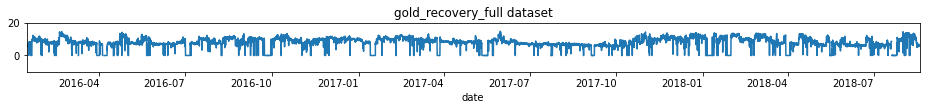

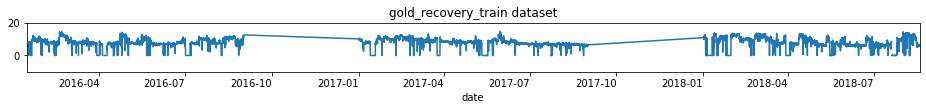

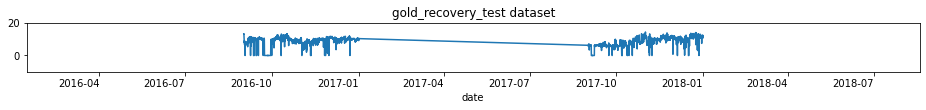

In [6]:
# plotting some data
for dataset in datasets:
    dataset.plot(
                 x='date', y=['rougher.input.feed_ag'], figsize=(16, 1),
                 legend=False, title=f'{dataset.name} dataset', rot=0, ylim=(-10, 20),
                 xlim=(gold_recovery_full.date.min(), gold_recovery_full.date.max())
                )

> This figure shows us, that the time frame, presented in the "gold_recovery_full" dataset spans from Jan 2016 till Sept 2018. Other two datasets have missing values, e.g. "gold_recovery_train" dataset lacks values from Sept 2016 till Jan 2017, and from Sept 2017 till Jan 2018. Furthermore, "gold_recovery_test" dataset has missing values from Jan 2016 till Sept 2016, then from Jan 2017 till Sept 2017, and finally from Jan 2018 till Sept 2018. 

**Conclusion:**

1. All datasets have missing values, however, it is very hard to fill them somehow due to the complexity of the gold ore extracting process, so we will leave it as it is for now.  
2. Some columns are missing in the `gold_recovery_test` dataset. Since it would be used to testing the model, we should not train these models on the columns which are missing in the test dataset.
3. The `date` column is not very important because the chemical process doesn't depend on the date and time - it is always the same if done in a closed environment (which we do not clearly know). But apparently, the ML model shouldn't rely on the date and time.
4. We see, that the gold mean concentration gradually increases after each cleaning stage. Similar happens to the tails with some small differences.
5. The dates, presented in all datasets differ in time frame. 


### Gold Recovery calculation

<img src="img/recovery.jpg" alt="recovery" width="600"/>

where:
- C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
- F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
- T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

In [7]:
def recovery_calculation(dataset):
    C = dataset['rougher.output.concentrate_au'] # share of gold in the concentrate right after flotation
    F = dataset['rougher.input.feed_au'] # share of gold in the feed before flotation
    T = dataset['rougher.output.tail_au'] # share of gold in the rougher tails right after flotation
    
    # recovery calculations
    dataset['recovery_calc'] = ((C * (F - T)) / (F * (C - T))) * 100
    
    # removing values higher than 100 and lower than 0
    dataset[dataset['recovery_calc'] > 100] = np.nan
    dataset[dataset['recovery_calc'] < 0] = np.nan
    
    return dataset

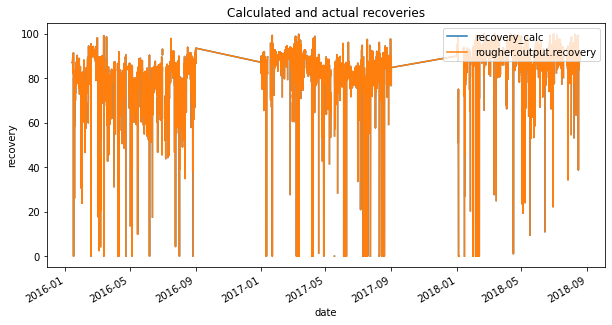

In [8]:
gold_recovery_train = recovery_calculation(gold_recovery_train)
mae = mean_absolute_error(gold_recovery_train['rougher.output.recovery'].fillna(0), gold_recovery_train['recovery_calc'].fillna(0))

ax = gold_recovery_train.plot(x='date', y='recovery_calc', figsize=(10, 5),
                             title='Calculated and actual recoveries', ylabel='recovery')
gold_recovery_train.plot(x='date', y='rougher.output.recovery', ax=ax)
ax.legend(loc=1)
plt.show()

> As we can see, the calculated recovery (blue line) completely matches with the real one (orange line).

In [9]:
print('Mean absolute error (MAE) between "rougher.output.recovery" feature and the calculated recovery = {:.3}'.format(mae))

Mean absolute error (MAE) between "rougher.output.recovery" feature and the calculated recovery = 7.88e-15


**Conclusion:**

The calculated and provided data about gold recovery completely matches each other. Furthermore, MAE shows that there is basically no difference between these values.

### Missing data in test dataset

In [10]:
print(f'"gold_recovery_test" dataset lacks {gold_recovery_train.shape[-1] - gold_recovery_test.shape[-1]} columns')
print('=' * 50)
print('These columns are: ')
display(gold_recovery_train.columns.difference(gold_recovery_test))

"gold_recovery_test" dataset lacks 35 columns
These columns are: 


Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

**Conclusion:**

The `gold_recovery_test` dataset lacks 35 columns with `float64` dtype. The columns refer to `final.output`, `primary_cleaner`, `rougher` values, and `secondary_cleaner` values. The data with the mark `calculation` shouldn't be taken into consideration during the ML preparation because they are calculated afterwards. Finally, only the data, which is presented in the `gold_recovery_test` dataset will be considered during the ML preparation because all the other data is received "post factum". So that means that we need to delete all columns in the `gold_recovery_train` which are missing in the `gold_recovery_test`.

### Data preprocessing

In [11]:
# let's look at the rows with the missing data
gold_recovery_full[gold_recovery_full.isnull().any(axis=1)].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,NaN,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,2016-01-17 01:00:00,7.256114,9.017677,NaN,43.389252,NaN,12.100582,1.758360,4.606019,3.202483,...,14.032364,-549.326033,11.987133,-549.583570,10.094584,-492.041563,8.054770,-498.802262,11.961330,-597.272218
50,2016-01-17 02:00:00,8.162896,8.877528,NaN,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,...,13.984906,-550.563329,11.999730,-550.549773,9.941869,-503.282068,8.018850,-500.970716,11.991078,-598.475929
53,2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.476280,...,13.972224,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399


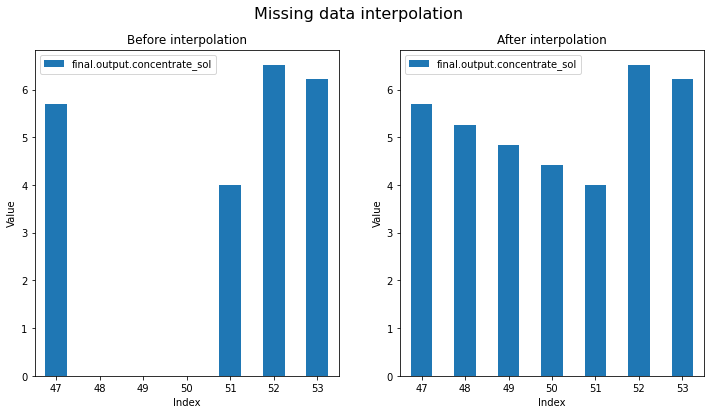

In [12]:
# data before interpolation
before_interp = gold_recovery_full.iloc[47:54, [3]]

# interpolating data in all three datasets
gold_recovery_full.loc[:, gold_recovery_full.columns != 'date'] = gold_recovery_full.loc[:, gold_recovery_full.columns != 'date'].interpolate(method='linear')
gold_recovery_train.loc[:, gold_recovery_train.columns != 'date'] = gold_recovery_train.loc[:, gold_recovery_train.columns != 'date'].interpolate(method='linear')
gold_recovery_test.loc[:, gold_recovery_test.columns != 'date'] = gold_recovery_test.loc[:, gold_recovery_test.columns != 'date'].interpolate(method='linear')

# data after interpolation
after_interp = gold_recovery_full.iloc[47:54, [3]]

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

before_interp.plot(kind='bar', ax=ax1, title='Before interpolation', rot=0)
ax1.set(xlabel='Index')
ax1.set(ylabel='Value')

after_interp.plot(kind='bar', ax=ax2, title='After interpolation', rot=0)
ax2.set(xlabel='Index')
ax2.set(ylabel='Value')

fig.suptitle('Missing data interpolation', fontsize=16)

plt.show()

> As we can see, values in some rows are not filled in for up to several hours. We have linearly interpolated the missing values.

## Data analysis

### Concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

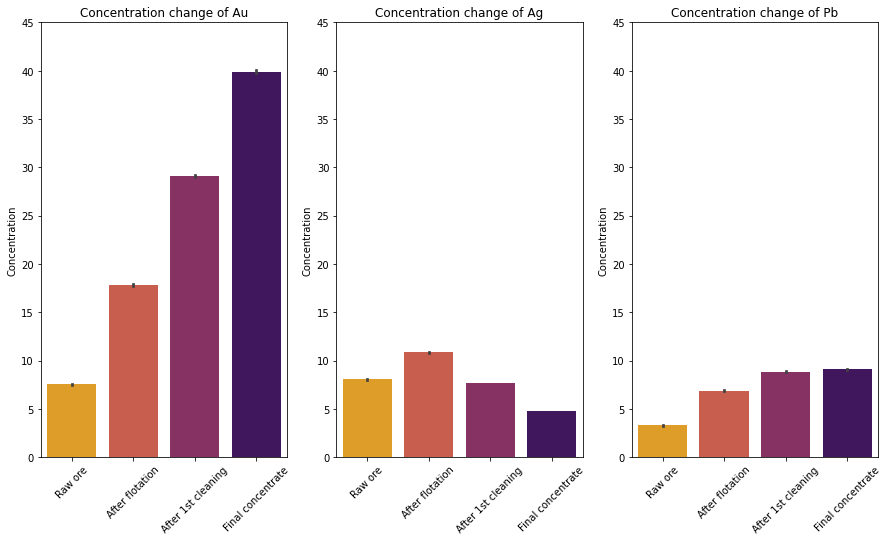

In [13]:
au_conc = ['rougher.input.feed_au','rougher.output.concentrate_au',
             'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']

ag_conc = ['rougher.input.feed_ag','rougher.output.concentrate_ag',
             'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']

pb_conc = ['rougher.input.feed_pb','rougher.output.concentrate_pb',
             'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

metals = [au_conc, ag_conc, pb_conc]
titles = ['Concentration change of Au', 'Concentration change of Ag', 'Concentration change of Pb']

fig, ax = plt.subplots(1, 3, figsize=(15,8))
for i in range(3):
    sns.barplot(data=gold_recovery_full[metals[i]], ax=ax[i], palette='inferno_r')
    ax[i].set_title(titles[i])
    ax[i].set(ylim=(0, 45))
    ax[i].set_xticklabels(['Raw ore','After flotation','After 1st cleaning','Final concentrate'], rotation=45)
    ax[i].set(ylabel='Concentration')
plt.show()

> As we can see, the gold concentration increases with every purification process. Similar thing happens to Pd, but it's concentrations are significantly smaller. In contrast, the concentration of Ag increases after the flotation process, but decreases with an every cleaning step. This is interesting, since by logic the cleaning processes should remove all other metals except of Au from the ore.

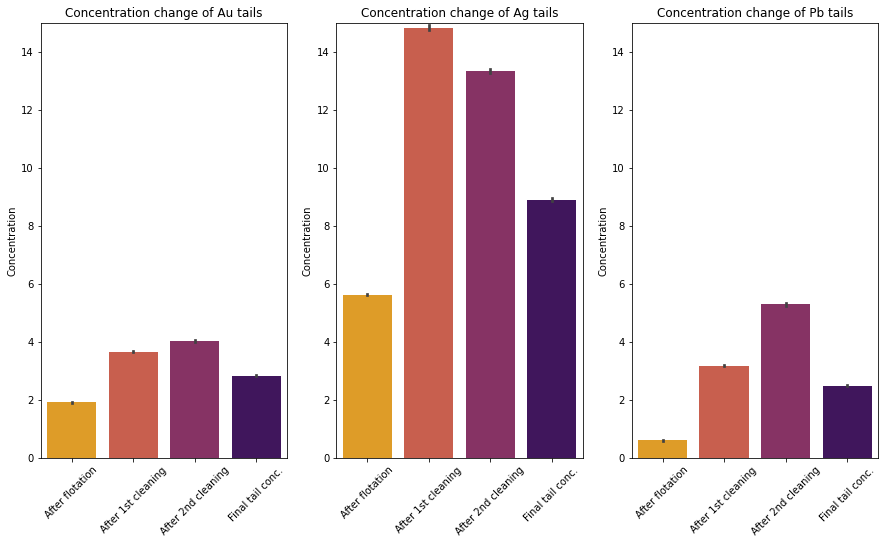

In [14]:
au_conc = ['rougher.output.tail_au','primary_cleaner.output.tail_au',
             'secondary_cleaner.output.tail_au', 'final.output.tail_au']

ag_conc = ['rougher.output.tail_ag','primary_cleaner.output.tail_ag',
             'secondary_cleaner.output.tail_ag', 'final.output.tail_ag']

pb_conc = ['rougher.output.tail_pb','primary_cleaner.output.tail_pb',
             'secondary_cleaner.output.tail_pb', 'final.output.tail_pb']

metals = [au_conc, ag_conc, pb_conc]
titles = ['Concentration change of Au tails', 'Concentration change of Ag tails', 'Concentration change of Pb tails']

fig, ax = plt.subplots(1, 3, figsize=(15,8))
for i in range(3):
    sns.barplot(data=gold_recovery_full[metals[i]], ax=ax[i], palette='inferno_r')
    ax[i].set_title(titles[i])
    ax[i].set(ylim=(0, 15))
    ax[i].set_xticklabels(['After flotation','After 1st cleaning', 'After 2nd cleaning', 'Final tail conc.'], rotation=45)
    ax[i].set(ylabel='Concentration')
plt.show()

> Here we can see that the gold concentration in tails also grows from the flotation till the 2nd cleaning process. However, the gold final tail concentration is smaller, possibly due to the fact that this concentration is a sum of all previous concentrations, and since concentration of the gold in tail after the flotation process was very small, we have such a value in the end. Maximum gold tail concentration equals to 5. In contrast, the silver tail concentrations are much higher and significantly increase after the 1st and the 2nd cleaning processes. The concentration of Pb remains small, but takes its maximum at the 2nd cleaning process.

###  Feed particle size distributions comparison

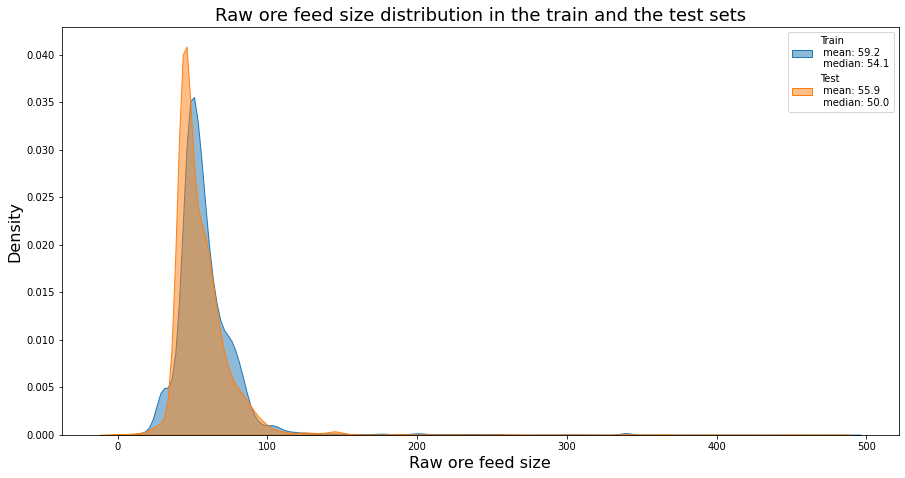

In [15]:
plt.figure(figsize=(15, 7.5))
sns.distplot(gold_recovery_train['rougher.input.feed_size'], hist=False,
             kde_kws={'shade':True, 'alpha':0.5},
             label=(f'Train\n mean: {round(gold_recovery_train["rougher.input.feed_size"].mean(),1)}\n median: {round(gold_recovery_train["rougher.input.feed_size"].median(),1)}'))
sns.distplot(gold_recovery_test['rougher.input.feed_size'], hist=False,
             kde_kws={'shade':True, 'alpha':0.5},
             label=(f'Test\n mean: {round(gold_recovery_test["rougher.input.feed_size"].mean(),1)}\n median: {round(gold_recovery_test["rougher.input.feed_size"].median(),1)}'))
plt.xlabel('Raw ore feed size', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Raw ore feed size distribution in the train and the test sets', fontsize=18)
plt.legend()
plt.show()

> In this picture we can see that the mean and median values as well as the particle size distributions of the test and train sets vary but not very significantly.

### Total concentrations of all substances at different stages

Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

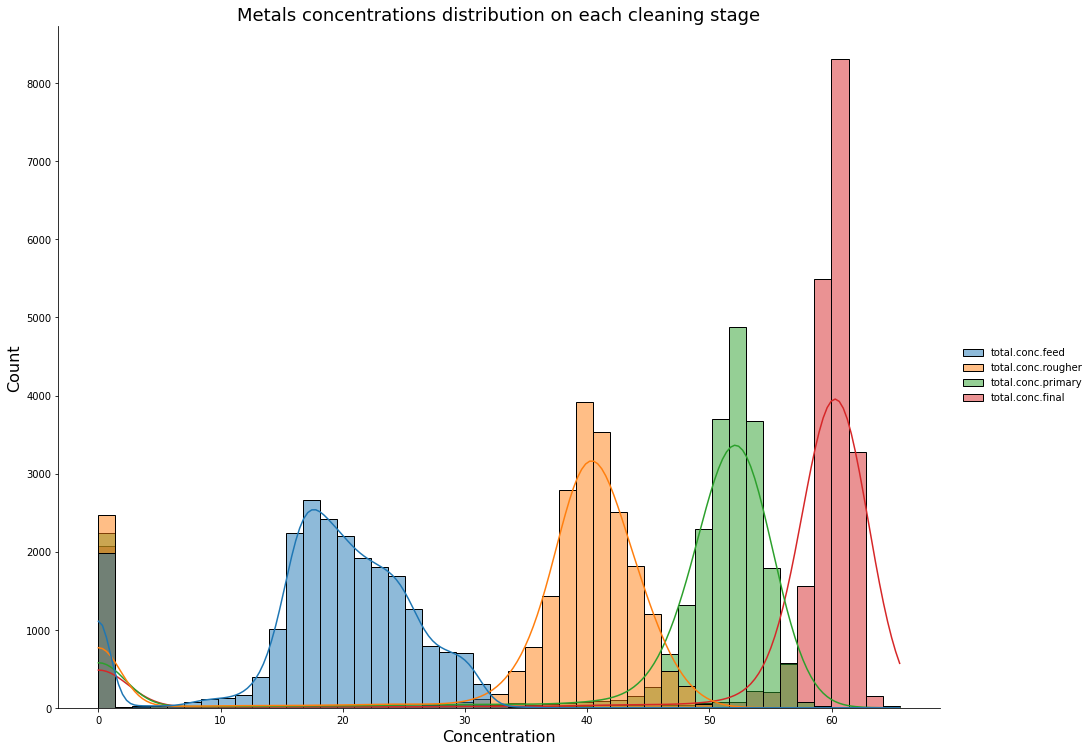

In [16]:
gold_recovery_full['total.conc.feed'] = gold_recovery_full[['rougher.input.feed_ag', 
                                                            'rougher.input.feed_pb',
                                                            'rougher.input.feed_au']].sum(axis=1)

gold_recovery_full['total.conc.rougher'] = gold_recovery_full[['rougher.output.concentrate_ag',
                                                                 'rougher.output.concentrate_pb',
                                                                 'rougher.output.concentrate_au']].sum(axis=1)

gold_recovery_full['total.conc.primary'] =  gold_recovery_full[['primary_cleaner.output.concentrate_ag',
                                                                'primary_cleaner.output.concentrate_pb',
                                                                'primary_cleaner.output.concentrate_au']].sum(axis=1)

gold_recovery_full['total.conc.final'] =  gold_recovery_full[['final.output.concentrate_ag',
                                                              'final.output.concentrate_pb',
                                                              'final.output.concentrate_au']].sum(axis=1)

# deleting the values which give very close to zero concentrations in sum
drop_list = ['total.conc.feed', 'total.conc.rougher', 'total.conc.primary', 'total.conc.final']

# drawing a plot
sns.displot(gold_recovery_full[['total.conc.feed', 'total.conc.rougher', 'total.conc.primary', 'total.conc.final']],
            height=10, aspect=2/1.5, kde=True)
plt.xlabel('Concentration', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Metals concentrations distribution on each cleaning stage', fontsize=18)
plt.show()

> As we can see from the histograms, the concentrations show normal distributions (except "feed"). We can observe how the metal concentrations increase and their distributions range decrease with an every cleaning stage. 
Furthermore, there are a plenty of total metal concentration values which are equal to 0 or are smaller than 0.1 in total. These values are mistakes, we do not need them for the ML part, hence they should be deleted.

### Cleaning data frames from incorrect values

In [17]:
# assigning `date` column as index
gold_recovery_full = gold_recovery_full.set_index('date')
gold_recovery_train = gold_recovery_train.set_index('date')
gold_recovery_test = gold_recovery_test.set_index('date')

In [18]:
# adding additional columns to the test dataset which were absent in it from the full dataset according to the `date` column
print(f'"gold_recovery_test" shape before merge: {gold_recovery_test.shape}')
gold_recovery_full_merged = gold_recovery_full[["rougher.output.recovery", "final.output.recovery",
                                                "rougher.output.concentrate_au", "rougher.output.concentrate_ag",
                                                "rougher.output.concentrate_pb", "final.output.concentrate_au",
                                                "final.output.concentrate_ag", "final.output.concentrate_pb",
                                                "primary_cleaner.output.concentrate_ag", "primary_cleaner.output.concentrate_pb",
                                                "primary_cleaner.output.concentrate_au"]]
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full_merged, on="date", how="left")
print(f'"gold_recovery_test" shape after merge: {gold_recovery_test.shape}')

"gold_recovery_test" shape before merge: (5856, 52)
"gold_recovery_test" shape after merge: (5856, 63)


In [19]:
features_input_concentrate = ['rougher.input.feed_au',
                              'rougher.input.feed_ag',
                              'rougher.input.feed_pb']
    
features_rougher_concentrate = ['rougher.output.concentrate_au',
                                'rougher.output.concentrate_ag',
                                'rougher.output.concentrate_pb']

features_primary_concentrate = ['primary_cleaner.output.concentrate_ag',
                                'primary_cleaner.output.concentrate_pb',
                                'primary_cleaner.output.concentrate_au']

features_final_concentrate = ['final.output.concentrate_au',
                              'final.output.concentrate_ag',
                              'final.output.concentrate_pb']

features = [features_input_concentrate, features_rougher_concentrate, features_primary_concentrate, features_final_concentrate]

print(f'"gold_recovery_full" shape before deleting zero sum. concentrations: {gold_recovery_full.shape}')
print(f'"gold_recovery_train" shape before deleting zero sum. concentrations: {gold_recovery_train.shape}')
print(f'"gold_recovery_test" shape before deleting zero sum. concentrations: {gold_recovery_test.shape}')

# cleaning process itself
for feature in features:
    gold_recovery_full = gold_recovery_full[gold_recovery_full[feature].sum(axis=1) > 0.1]
    gold_recovery_train = gold_recovery_train[gold_recovery_train[feature].sum(axis=1) > 0.1]
    gold_recovery_test = gold_recovery_test[gold_recovery_test[feature].sum(axis=1) > 0.1]   
    
print('='*50)
print(f'"gold_recovery_full" shape after deleting zero sum. concentrations: {gold_recovery_full.shape}')
print(f'"gold_recovery_train" shape after deleting zero sum. concentrations: {gold_recovery_train.shape}')
print(f'"gold_recovery_test" shape after deleting zero sum. concentrations: {gold_recovery_test.shape}')

"gold_recovery_full" shape before deleting zero sum. concentrations: (22716, 90)
"gold_recovery_train" shape before deleting zero sum. concentrations: (16860, 87)
"gold_recovery_test" shape before deleting zero sum. concentrations: (5856, 63)
"gold_recovery_full" shape after deleting zero sum. concentrations: (19617, 90)
"gold_recovery_train" shape after deleting zero sum. concentrations: (14486, 87)
"gold_recovery_test" shape after deleting zero sum. concentrations: (5257, 63)


**Cleaning the train dataset from missing columns in the test dataset**

In [20]:
# getting the list of missing columns in the test dataset in comparison to train dataset
missed_test_columns = set(list(gold_recovery_train.columns.values))-set(list(gold_recovery_test.columns.values))

# leaving in the train dataset only those which are present in the test dataset
gold_recovery_train = gold_recovery_train.drop(missed_test_columns, axis=1)
print(f'"gold_recovery_train" shape after deleting columns that are not present in the test dataset: {gold_recovery_train.shape}')

"gold_recovery_train" shape after deleting columns that are not present in the test dataset: (14486, 63)


**Conclusion:** Total metal concentrations and feed particle sizes have been plotted in this section. The rows with total metal concentration < 0.1 have been deleted since this are mistakes.

## Model preparation

<img src="img/smape.jpg" alt="smape" width="600"/>
<img src="img/smape_final.jpg" alt="smape_final" width="600"/>

We will use a custom metric for evaluation of our models. It is called `sMAPE`, **symmetric Mean Absolute Percentage Error**.
It is similar to MAE, but is expressed in relative values instead of absolute ones. Why is it symmetrical? It equally takes into account the scale of both the target and the prediction.

We need to predict two values:
1. rougher concentrate recovery `rougher.output.recovery`
2. final concentrate recovery `final.output.recovery`

Thus, for predicting `rougher.output.recovery`, we need to exclude all other columns with are related to later stages, because they will not give us any valuable info.

#### sMAPE and Final sMAPE functions

In [21]:
#function to calcualte sMAPE score for predicted and actual values
def smape(y, y_pred):
    smape = 1/len(y) *np.sum(np.abs(y - y_pred)*2*100/((np.abs(y) + np.abs(y_pred))))
    return smape

def final_smape(rougher_smape, final_smape):
    return 0.25 * rougher_smape + 0.75 * final_smape

#convert it to sklearn function so it can be directly attached to CV scoring parameter
smape_scorer=make_scorer(smape, greater_is_better=False)

#### Features and targets preparation

In [22]:
features_final = gold_recovery_test.columns.tolist()
features_rougher = [x for x in gold_recovery_test.columns.tolist() if 'rougher' in x.split('.')]

print(f'"Final" features contain {len(features_final)} columns\n"Rougher" features contain {len(features_rougher)} columns')

"Final" features contain 63 columns
"Rougher" features contain 26 columns


In [23]:
# making targets and features for `rougher.output.recovery` prediction

# train targets and features
features_rougher_train =  gold_recovery_train[features_rougher].drop('rougher.output.recovery', axis=1).reset_index(drop=True)
target_rougher_train = gold_recovery_train['rougher.output.recovery'].reset_index(drop=True)

# test targets and features
features_rougher_test = gold_recovery_test[features_rougher].drop('rougher.output.recovery', axis=1).reset_index(drop=True)
target_rougher_test = gold_recovery_test['rougher.output.recovery'].reset_index(drop=True)


# making targets and features for `final.output.recovery` prediction

# train targets and features
features_final_train = gold_recovery_train[features_final].drop('final.output.recovery', axis=1).reset_index(drop=True)
target_final_train = gold_recovery_train['final.output.recovery'].reset_index(drop=True)

# test targets and features
features_final_test = gold_recovery_test[features_final].drop('final.output.recovery', axis=1).reset_index(drop=True)
target_final_test = gold_recovery_test['final.output.recovery'].reset_index(drop=True)

#### Establishing Pipeline and GridSearchCV parameters

In [24]:
# setting up testing range for models' parameters and the random state
state = RandomState(42)
test_range = list(range(1, 11))
cv = 5

# initializing StandartScaler()
scaler = StandardScaler()

# initializing models, which we will use for predictions
model_1 = LinearRegression()
model_2 = DecisionTreeRegressor(random_state = state)
model_3 = RandomForestRegressor(random_state = state)

# setting up the pipeline
pipeline = Pipeline([('scaler', scaler), ('classifier', model_1)])

# parameters for the model 1
params_1 = {}
params_1['classifier'] = [model_1]

# parameters for the model 2
params_2 = {}
params_2['classifier__max_depth'] = test_range
params_2['classifier'] = [model_2]

# parameters for the model 3
params_3 = {}
params_3['classifier__n_estimators'] = test_range
params_3['classifier__max_depth'] = test_range
params_3['classifier'] = [model_3]

# including all models' parameters to the list
params = [params_1, params_2, params_3]

#### `rougher.output.recovery` prediction

In [25]:
grid_rougher = GridSearchCV(pipeline, params, cv=cv, n_jobs=-1, scoring=smape_scorer)
grid_rougher.fit(features_rougher_train, target_rougher_train)
pd.DataFrame(grid_rougher.cv_results_)[['mean_test_score', 'std_test_score', 'params', 'rank_test_score']].sort_values('rank_test_score').head()

,mean_test_score,std_test_score,params,rank_test_score
0,-6.465766,1.224090,"{'classifier': LinearRegression(copy_X=True, f...",1
34,-6.798960,0.999430,{'classifier': RandomForestRegressor(bootstrap...,2
44,-6.805756,0.907807,{'classifier': RandomForestRegressor(bootstrap...,3
33,-6.870288,1.058457,{'classifier': RandomForestRegressor(bootstrap...,4
43,-6.874998,0.916816,{'classifier': RandomForestRegressor(bootstrap...,5


In [26]:
print(f'Best model parameters for predicting "rougher.output.recovery":\n{grid_rougher.best_params_}')

Best model parameters for predicting "rougher.output.recovery":
{'classifier': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}


#### `final.output.recovery` prediction

In [27]:
grid_final = GridSearchCV(pipeline, params, cv=cv, n_jobs=-1, scoring=smape_scorer)
grid_final.fit(features_final_train, target_final_train)
pd.DataFrame(grid_final.cv_results_)[['mean_test_score', 'std_test_score', 'params', 'rank_test_score']].sort_values('rank_test_score').head()

,mean_test_score,std_test_score,params,rank_test_score
38,-8.393856,0.539119,{'classifier': RandomForestRegressor(bootstrap...,1
46,-8.396150,0.315525,{'classifier': RandomForestRegressor(bootstrap...,2
37,-8.397401,0.529215,{'classifier': RandomForestRegressor(bootstrap...,3
48,-8.404139,0.254632,{'classifier': RandomForestRegressor(bootstrap...,4
36,-8.415617,0.515438,{'classifier': RandomForestRegressor(bootstrap...,5


In [28]:
print(f'Best model parameters for predicting "final.output.recovery":\n{grid_final.best_params_}')

Best model parameters for predicting "final.output.recovery":
{'classifier': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=8, n_jobs=None, oob_score=False,
                      random_state=RandomState(MT19937) at 0x1B32DFCD7B8,
                      verbose=0, warm_start=False), 'classifier__max_depth': 3, 'classifier__n_estimators': 8}


**Conclusion:** we have found out that `LinearRegression()` is the best model for predicting `rougher.output.recovery` and `RandomForestRegressor()` with (`max_depth=3`, and `n_estimators=8`) is the best model for predicting `final.output.recovery`.

## Final model training and evaluation using the test set
Let's use these two best models for our final predictions.

### `rougher.output.recovery` prediction

In [29]:
# initializing and fitting the best model for `rougher.output.recovery` 
rougher_model = LinearRegression()
rougher_model.fit(features_rougher_train, target_rougher_train)

# making predictions for the test dataset
rougher_predictions = rougher_model.predict(features_rougher_test)

#calculating SMAPE score
rougher_score = smape(target_rougher_test, rougher_predictions)

### `final.output.recovery` prediction

In [30]:
# initializing and fitting the best model for `rougher.output.recovery` 
final_model = RandomForestRegressor(random_state=state, n_estimators=8, max_depth=8)
final_model.fit(features_final_train, target_final_train)

# making predictions for the test dataset
final_predictions = final_model.predict(features_final_test)

#calculating SMAPE score
final_score = smape(target_final_test, final_predictions)

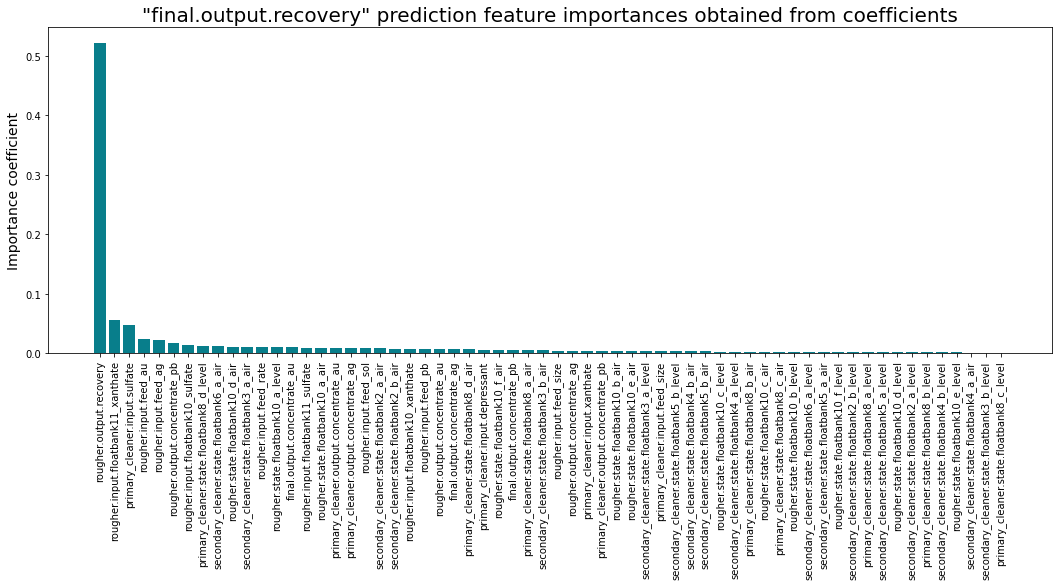

In [31]:
importances = pd.DataFrame(data={
    'Attribute': features_final_train.columns,
    'Importance': final_model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(18, 6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('"final.output.recovery" prediction feature importances obtained from coefficients', size=20)
plt.ylabel('Importance coefficient', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

> We can see, that that `rougher.output.recovery` is the most important parameter for predicting the `final.output.recovery` with an importance coefficient more than 0.5.

### Final sMAPE calculations

In [32]:
result = final_smape(rougher_score, final_score)

print(f'sMAPE score of the "rougher" stage: {round(rougher_score, 2)}')
print(f'sMAPE score of the "final" stage: {round(final_score, 2)}')
print(f'Final sMAPE score for the selected models is: {round(result, 2)}')

sMAPE score of the "rougher" stage: 4.43
sMAPE score of the "final" stage: 7.17
Final sMAPE score for the selected models is: 6.48


## Final conclusion

In this project:
1. We have analyzed 3 received datasets and understood, how are they connected to each other.
2. Later, the gold recovery calculation has been performed in order to understand how the real data meets the calculations. It turns out that the real and calculated prediction match each other perfectly. 
3. Furthermore, the missing data in the datasets have have been interpolated. Additionally, we have found out, that the test dataset lack 35 columns. Those columns can't be used in the training dataset to prevent leakage. 
4. The metals and tails concentrations have been analyzed on the each cleaning step. We could observe that the gold concentration increases after each subsequent cleaning stage.
5. Raw ore feed size distributions in the train and test datasets have been visualized. The mean values are `59` and `56`, respectively and do not posses significant differences in the distribution.
6. Later, total metal concentrations (Au, Ag, and Pb) and their distributions have been visualized on the each cleaning step. We concluded, that the total concentrations increase and their distributions decrease with the each cleaning step (as it should be). Furthermore, the there have been issues with the total metal values which equal less than `0.1`. All these data are mistakes and have been deleted since they are useless for the further predictions. 
7. We have written 2 functions for a new metric calculation (`sMAPE `and `Final sMAPE`)
8. The training and test data was split for both `rougher.output.recovery` and `final.output.recovery` calculations. Since the "rougher" stage is in the beginning, and the data from later stages couldn't influence this value, we have deleted all this data. On the other hand, the "final" stage included all the available data for training and testing.
9. In order to make automatisation of the best model and hyper-parameters searching procedure + data normalization we applied Pipeline and GridSearchCV together to test LinearRegression, DecisionTreeRegressor, and RandomForestRegressor models. In turns out, that `LinearRegression` works best for `rougher.output.recovery` prediction, while `RandomForestRegressor` (with `max_depth=3`, and `n_estimators=8`) works best for prediction `final.output.recovery`. We have found best hyper-parameters for the RandomForestRegressor model and calculated the final metric using the two above-mentioned models. The `Final sMAPE` score for the selected models is: `6.48`, which is decent (we need to minimize this value).
10. It turns out, that the most important parameter for predicting the `final.output.recovery` is `rougher.output.recovery` with an importance coefficient more than 0.5.